# Finger 2

- Encontrar los 5 anuncios cuya tasa de conversión (postulaciones al anuncio sobre visitas totales al anuncio) es la más alta.
    - Nota: Tener en cuenta que es posible que por ejemplo un anuncio con una visita y una postulación quede primero. Para evitar este inconveniente, tomar únicamente los avisos que poseen al menos un 25% de las visitas promedio que poseen los avisos. Por ejemplo, si el promedio de visitas de los avisos es 100, tomar solo los avisos que tengan al menos 25 visitas.
    - Nota2: Tener en cuenta también que los datos de vistas están incompletos. Solo podrá obtenerse la tasa de conversión para el período donde se tengan ambas informaciones (postulaciones y vistas).

---

- Indicar la distribución de la edad de los postulantes

---

- Realizar una visualización que nos permita analizar la evolución de cantidad de visitas por día y el nivel de estudio alcanzado por el postulante. El tipo de visualización será propuesto por el alumno.
    - Nota: Tener en cuenta que el nivel educativo del postulante dependerá de si el mismo fue completado, abandonado etc, por lo que para definir un nivel de estudio alcanzado hay que considerar tanto el nivel de estudios como el estado en el que se encuentra para el postulante: (Por ejemplo “Universitario En Curso” o “Universitario Abandonado” son casos válidos).

In [59]:
%matplotlib inline

import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('default') # haciendo los graficos un poco mas bonitos xD
plt.rcParams['figure.figsize'] = (15, 5)

try: 
    type(sc)
except NameError:
    sc = pyspark.SparkContext('local[*]')
    spark = pyspark.sql.SparkSession(sc)

In [60]:
vistas = sc.textFile('./fiuba_3_vistas.csv')
vistas.take(2)

[u'idAviso,timestamp,idpostulante',
 u'1111780242,2018-02-23T13:38:13.187-0500,YjVJQ6Z']

In [61]:
postulaciones = sc.textFile('./fiuba_4_postulaciones.csv')
postulaciones.take(2)

[u'idaviso,idpostulante,fechapostulacion',
 u'1112257047,NM5M,2018-01-15 16:22:34']

In [62]:
avisos = sc.textFile('./fiuba_6_avisos_detalle.csv')
avisos.take(2)

[u'idaviso,idpais,titulo,descripcion,nombre_zona,ciudad,mapacalle,tipo_de_trabajo,nivel_laboral,nombre_area,denominacion_empresa',
 u'8725750,1,VENDEDOR/A PROVINCIA DE SANTA FE,"<p><strong><strong>Empresa:</strong></strong> Distribuidor de repuestos automotor, Importador y Distribuidor de correas agr\xedcolas, industriales y automotor en Argentina</p><p><strong><strong>Sexo Postulante:</strong></strong> Indistinto</p><p><strong><strong>\xc1rea:</strong></strong> Ventas</p><p><strong><strong>Pa\xeds/Ciudad:</strong></strong> Argentina, Rosario y Santa Fe</p><p><strong><strong>Industria:</strong></strong> Automotriz</p><p><strong><strong>Salario: </strong></strong>Comisi\xf3n sobre ventas</p><p><strong><strong>Vacantes:1</strong></strong></p><p><strong><strong>Tipo de puesto de trabajo:</strong></strong> Full-time</p><p>Nuestra empresa es distribuidora mayorista de repuestos para automotor. Importamos y distribu\xedmos correas agr\xedcolas e industriales</p><p>Buscamos un\xa0 representan

In [63]:
postulantes_educacion = sc.textFile('./fiuba_1_postulantes_educacion.csv')
postulantes_educacion.take(2)

[u'idpostulante,nombre,estado', u'NdJl,Posgrado,En Curso']

## Punto 1

### Pre procesamiento

In [64]:
vistas = vistas.map(lambda x: tuple(x.split(','))).cache()
vistas.take(5)

[(u'idAviso', u'timestamp', u'idpostulante'),
 (u'1111780242', u'2018-02-23T13:38:13.187-0500', u'YjVJQ6Z'),
 (u'1112263876', u'2018-02-23T13:38:14.296-0500', u'BmVpYoR'),
 (u'1112327963', u'2018-02-23T13:38:14.329-0500', u'wVkBzZd'),
 (u'1112318643', u'2018-02-23T13:38:17.921-0500', u'OqmP9pv')]

In [65]:
postulaciones = postulaciones.map(lambda x: tuple(x.split(','))).cache()
postulaciones.take(5)

[(u'idaviso', u'idpostulante', u'fechapostulacion'),
 (u'1112257047', u'NM5M', u'2018-01-15 16:22:34'),
 (u'1111920714', u'NM5M', u'2018-02-06 09:04:50'),
 (u'1112346945', u'NM5M', u'2018-02-22 09:04:47'),
 (u'1112345547', u'NM5M', u'2018-02-22 09:04:59')]

In [66]:
vistas = vistas.map(lambda x: (x[0], 1)).reduceByKey(lambda x,y: x+y).cache()
promedio_vistas = vistas.map(lambda x: x[1]).reduce(lambda x,y: x + y) / vistas.count()
print(promedio_vistas)
vistas = vistas.filter(lambda x: x[1] > promedio_vistas * 0.25)
vistas.takeOrdered(5, key=lambda x: -x[1])

128


[(u'1112363488', 4169),
 (u'1112359836', 4120),
 (u'1112352317', 4003),
 (u'1112366909', 3669),
 (u'1112355872', 3472)]

In [67]:
postulaciones = postulaciones.map(lambda x: (x[0], 1)).reduceByKey(lambda x,y: x+y).cache()
postulaciones.takeOrdered(5, key=lambda x: -x[1])

[(u'1112033906', 9932),
 (u'1112334791', 9787),
 (u'1112204682', 9244),
 (u'1112094756', 8763),
 (u'1112345900', 8304)]

In [68]:
joined = postulaciones.join(vistas)
top_cinco = joined.filter(lambda x: x[1][0] <= x[1][1]).map(lambda x: (x[0], (x[1][0]/float(x[1][1])))).takeOrdered(5, key=lambda x: -x[1])
top_cinco

[(u'1112359543', 1.0),
 (u'1112369217', 1.0),
 (u'1112344695', 0.9951807228915662),
 (u'1112356486', 0.9914529914529915),
 (u'1112350288', 0.9911111111111112)]

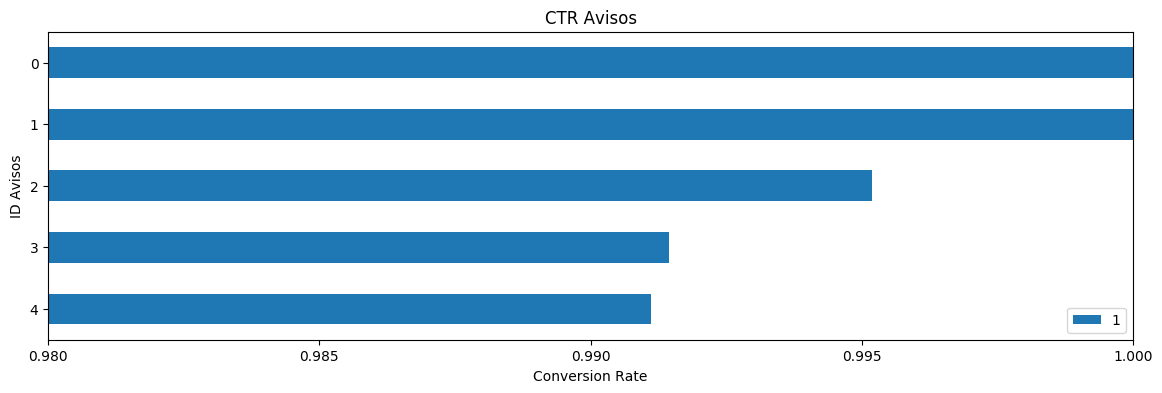

In [69]:
top_cinco_df = pd.DataFrame(top_cinco)
top_cinco_df.plot(kind='barh', figsize=(14,4));
ax=plt.gca();
ax.invert_yaxis();
ax.set_ylabel('ID Avisos');
ax.set_xlabel('Conversion Rate');
ax.set_title('CTR Avisos');
plt.xlim(0.98, 1.0);
plt.xticks(np.arange(0.98, 1, step=0.005));

In [75]:
ctrs = joined.filter(lambda x: x[1][0] <= x[1][1]).map(lambda x: (x[0], (x[1][0]/float(x[1][1])))).collect()

In [76]:
ctrs = pd.DataFrame(ctrs)

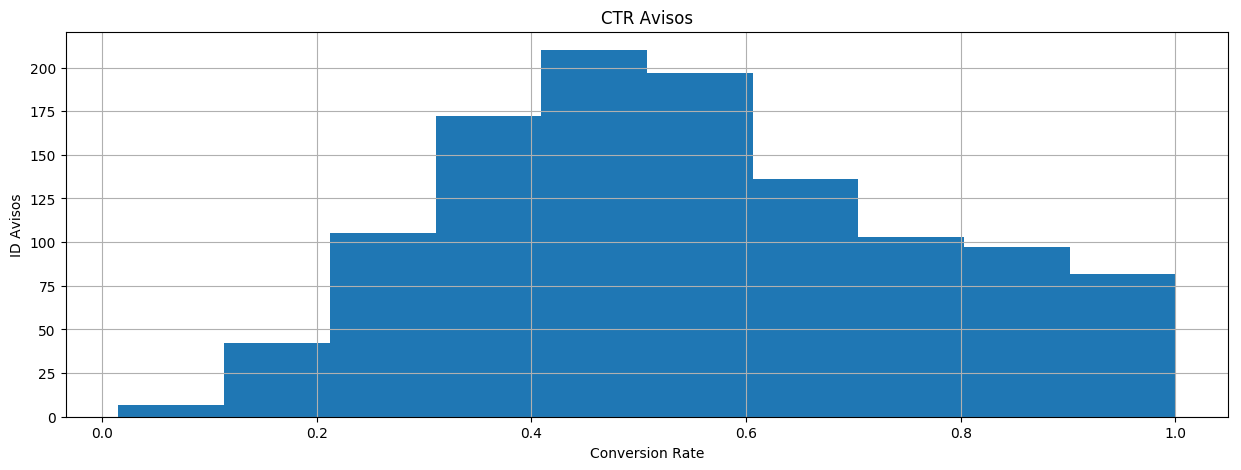

In [85]:
ctrs.hist()
ax=plt.gca();
ax.set_ylabel('ID Avisos');
ax.set_xlabel('Conversion Rate');
ax.set_title('CTR Avisos');

In [57]:
top_cinco = list(map(lambda x: x[0], top_cinco))
print('Top 5 Avisos con mas conversion rate', top_cinco)
print('Valido que todos tengan mas del 0.25 de la media y que realmente hay uno que tiene igual cantida', joined.filter(lambda x: x[0] in top_cinco).collect())

('Top 5 Avisos con mas conversion rate', [u'1112359543', u'1112369217', u'1112344695', u'1112356486', u'1112350288'])
('Valido que todos tengan mas del 0.25 de la media y que realmente hay uno que tiene igual cantida', [(u'1112356486', (580, 585)), (u'1112359543', (42, 42)), (u'1112369217', (150, 150)), (u'1112344695', (413, 415)), (u'1112350288', (223, 225))])


## Punto 2

In [29]:
postulantes_genero_y_edad = sc.textFile('./fiuba_2_postulantes_genero_y_edad.csv')
postulantes_genero_y_edad.take(2)

[u'idpostulante,fechanacimiento,sexo', u'NM5M,1970-12-03,FEM']

In [30]:
postulantes_genero_y_edad = postulantes_genero_y_edad.map(lambda x: tuple(x.split(','))).cache()
postulantes_genero_y_edad.take(5)

[(u'idpostulante', u'fechanacimiento', u'sexo'),
 (u'NM5M', u'1970-12-03', u'FEM'),
 (u'5awk', u'1962-12-04', u'FEM'),
 (u'ZaO5', u'1978-08-10', u'FEM'),
 (u'NdJl', u'1969-05-09', u'MASC')]

In [31]:
def fecha_a_anio(fecha):
    anio = fecha.split('-')[0]
    return int(anio) if anio.isnumeric() else 0
    
def anio_a_edad(anio):
    return 2018 - anio

postulantes_genero_y_edad = (postulantes_genero_y_edad
                             .filter(lambda x: x[0] != 'idpostulante')
                             .map(lambda x: (x[0], fecha_a_anio(x[1])))
                             .filter(lambda x: x[1] > 1980)
                             .map(lambda x: (x[0], anio_a_edad(x[1])))
                             .cache())
postulantes_genero_y_edad.takeOrdered(10, key=lambda x: -x[1])

[(u'eo2p', 37),
 (u'NPBx', 37),
 (u'N033D', 37),
 (u'epYJB', 37),
 (u'8j0lL', 37),
 (u'NZpLL', 37),
 (u'eLZPj', 37),
 (u'6k5OGj', 37),
 (u'Y0OAqJ', 37),
 (u'52QElN', 37)]

### Distribucion de edades de postulantes

In [32]:
postulantes_genero_y_edad = postulantes_genero_y_edad.map(lambda x: (x[1], 1)).reduceByKey(lambda x,y: x+y).cache()
postulantes_genero_y_edad.takeOrdered(10, key=lambda x: -x[0])

[(37, 4655),
 (36, 5018),
 (35, 5447),
 (34, 5871),
 (33, 6673),
 (32, 7644),
 (31, 8283),
 (30, 9161),
 (29, 9914),
 (28, 11064)]

### Grafico de distribucion de edades de postulantes

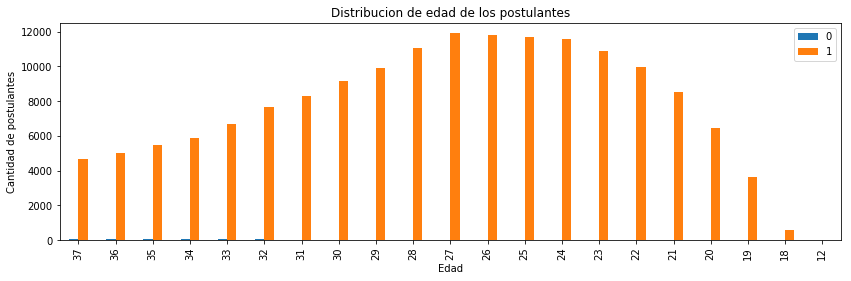

In [33]:
x_label = postulantes_genero_y_edad.map(lambda x: x[0]).takeOrdered(100, key=lambda x: -x)
df = pd.DataFrame(postulantes_genero_y_edad.takeOrdered(100, key=lambda x: -x[0]))
df.plot(kind='bar', figsize=(14,4));
ax=plt.gca()
ax.set_ylabel('Cantidad de postulantes')
ax.set_xlabel('Edad');
ax.set_title('Distribucion de edad de los postulantes');
plt.xticks(range(len(x_label)), x_label);

## Punto 3

In [36]:
from datetime import datetime as dt
vistas = sc.textFile('./fiuba_3_vistas.csv')
vistas.take(2)

[u'idAviso,timestamp,idpostulante',
 u'1111780242,2018-02-23T13:38:13.187-0500,YjVJQ6Z']

In [37]:
def toDate(date_str):
    date = pd.to_datetime(date_str)
    return date.date()#.isoformat()

vistas = vistas.map(lambda x: tuple(x.split(','))).filter(lambda x: x[0] != 'idAviso').map(lambda x: (toDate(x[1]), 1)).reduceByKey(lambda x,y: x+y).sortByKey().cache()
vistas.take(5)

[(datetime.date(2018, 2, 23), 47236),
 (datetime.date(2018, 2, 24), 95930),
 (datetime.date(2018, 2, 25), 90646),
 (datetime.date(2018, 2, 26), 227957),
 (datetime.date(2018, 2, 27), 232145)]

### Grafico de cantidad de vistas por dia

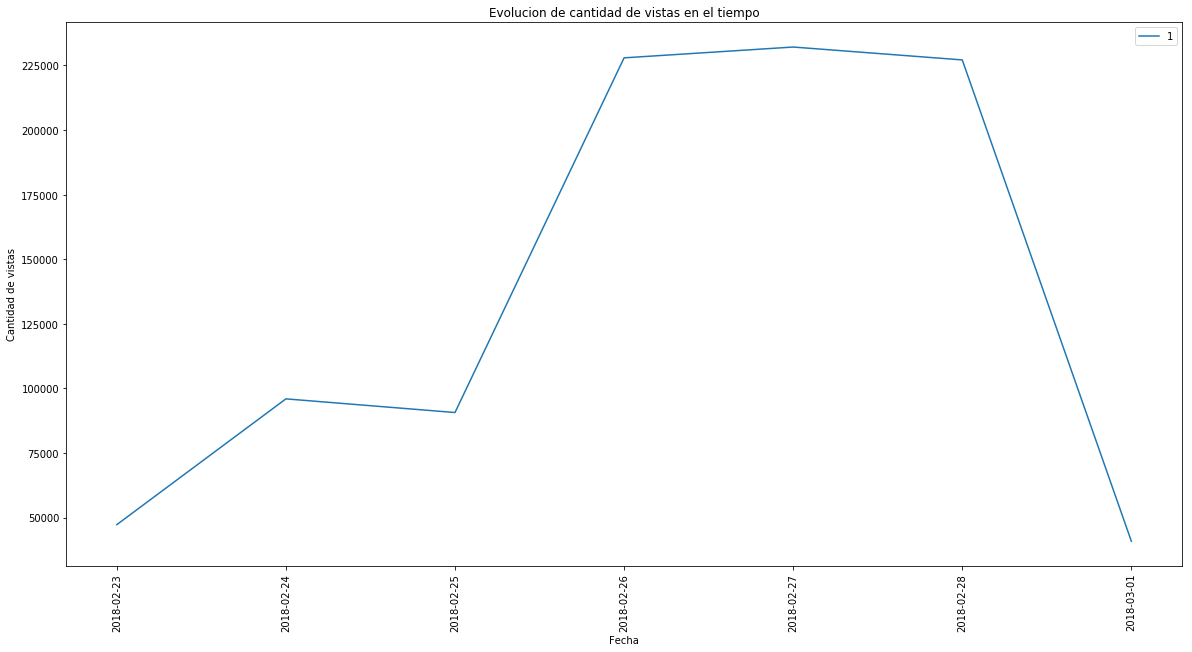

In [38]:
x_label = vistas.map(lambda x: x[0]).collect()
df = pd.DataFrame(vistas.collect())
df.plot(figsize=(20,10));
ax=plt.gca()
ax.set_ylabel('Cantidad de vistas')
ax.set_xlabel('Fecha');
ax.set_title('Evolucion de cantidad de vistas en el tiempo');
plt.xticks(range(len(x_label)), x_label, rotation='vertical');

### Cantidad de vistas por dia por nivel educativo

In [39]:
from datetime import datetime as dt
vistas = sc.textFile('./fiuba_3_vistas.csv')
vistas.take(2)

[u'idAviso,timestamp,idpostulante',
 u'1111780242,2018-02-23T13:38:13.187-0500,YjVJQ6Z']

In [40]:
def toDate(date_str):
    date = pd.to_datetime(date_str)
    return date.date()#.isoformat()

vistas = vistas.map(lambda x: tuple(x.split(','))).filter(lambda x: x[0] != 'idAviso').map(lambda x: ((x[2], toDate(x[1])), 1)).reduceByKey(lambda x,y: x+y).cache()
vistas.take(5)

[((u'5RdVdw', datetime.date(2018, 2, 28)), 7),
 ((u'wVkm3Kl', datetime.date(2018, 2, 26)), 2),
 ((u'BmDMRDL', datetime.date(2018, 2, 27)), 6),
 ((u'VNeJJwR', datetime.date(2018, 2, 27)), 11),
 ((u'xk9pQRa', datetime.date(2018, 2, 25)), 3)]

In [41]:
vistas = vistas.map(lambda x: (x[0][0], (x[0][1], x[1]))).cache()
vistas.take(5)

[(u'5RdVdw', (datetime.date(2018, 2, 28), 7)),
 (u'wVkm3Kl', (datetime.date(2018, 2, 26), 2)),
 (u'BmDMRDL', (datetime.date(2018, 2, 27), 6)),
 (u'VNeJJwR', (datetime.date(2018, 2, 27), 11)),
 (u'xk9pQRa', (datetime.date(2018, 2, 25), 3))]

In [42]:
postulantes_educacion = sc.textFile('./fiuba_1_postulantes_educacion.csv')
postulantes_educacion = postulantes_educacion.map(lambda x: tuple(x.split(','))).filter(lambda x: x[0] != 'idpostulante').map(lambda x: (x[0], (x[1], x[2]))).cache()
postulantes_educacion.take(2)

[(u'NdJl', (u'Posgrado', u'En Curso')),
 (u'8BkL', (u'Universitario', u'En Curso'))]

In [43]:
joined = vistas.join(postulantes_educacion).cache()
joined.take(5)

[(u'W9VopPX', ((datetime.date(2018, 2, 25), 7), (u'Posgrado', u'Abandonado'))),
 (u'2zPbD1V', ((datetime.date(2018, 2, 26), 4), (u'Secundario', u'Graduado'))),
 (u'2zPbD1V',
  ((datetime.date(2018, 2, 23), 18), (u'Secundario', u'Graduado'))),
 (u'lDXprv3',
  ((datetime.date(2018, 2, 26), 10), (u'Universitario', u'Graduado'))),
 (u'lDXprv3',
  ((datetime.date(2018, 2, 28), 1), (u'Universitario', u'Graduado')))]

In [44]:
joined = joined.map(lambda x: ((x[1][1], x[1][0][0]),  x[1][0][1])).reduceByKey(lambda x,y: x+y)
joined.take(5)

[(((u'Secundario', u'Abandonado'), datetime.date(2018, 2, 24)), 1205),
 (((u'Secundario', u'Graduado'), datetime.date(2018, 2, 28)), 117650),
 (((u'Doctorado', u'En Curso'), datetime.date(2018, 2, 23)), 10),
 (((u'Posgrado', u'Graduado'), datetime.date(2018, 2, 28)), 4777),
 (((u'Otro', u'Abandonado'), datetime.date(2018, 2, 23)), 129)]

In [27]:
joined_df = joined.map(lambda x: ('/'.join(x[0][0]), x[0][1], x[1])).toDF().toPandas()
joined_df.columns = ['educacion', 'fecha', 'vistas']
joined_df = joined_df.pivot(index='fecha', columns='educacion', values='vistas')
joined_df = joined_df.fillna(0)
joined_df.head()

educacion,Doctorado/Abandonado,Doctorado/En Curso,Doctorado/Graduado,Master/Abandonado,Master/En Curso,Master/Graduado,Otro/Abandonado,Otro/En Curso,Otro/Graduado,Posgrado/Abandonado,...,Posgrado/Graduado,Secundario/Abandonado,Secundario/En Curso,Secundario/Graduado,Terciario/Técnico/Abandonado,Terciario/Técnico/En Curso,Terciario/Técnico/Graduado,Universitario/Abandonado,Universitario/En Curso,Universitario/Graduado
fecha,,,,,,,,,,,,,,,,,,,,,
2018-02-23,2.0,10.0,8.0,9.0,241.0,366.0,129.0,1168.0,3797.0,108.0,...,991.0,571.0,814.0,23910.0,1209.0,3927.0,6228.0,3815.0,14717.0,9355.0
2018-02-24,0.0,25.0,24.0,41.0,597.0,955.0,337.0,2198.0,7827.0,186.0,...,2082.0,1205.0,1667.0,49203.0,2538.0,6657.0,12431.0,8025.0,26144.0,18244.0
2018-02-25,4.0,27.0,30.0,44.0,589.0,887.0,420.0,1993.0,7538.0,183.0,...,2353.0,1166.0,1427.0,45247.0,2807.0,6690.0,11378.0,7476.0,24036.0,17623.0
2018-02-26,36.0,101.0,204.0,228.0,1449.0,1777.0,1102.0,5376.0,19376.0,401.0,...,5212.0,2743.0,3509.0,117398.0,6259.0,17696.0,31513.0,19045.0,64977.0,45424.0
2018-02-27,7.0,68.0,124.0,206.0,1537.0,1733.0,812.0,4834.0,18638.0,302.0,...,5018.0,2699.0,3938.0,120897.0,7306.0,17886.0,30997.0,18452.0,67838.0,45167.0


### Grafico de cantidad de vistas por dia por nivel educativo

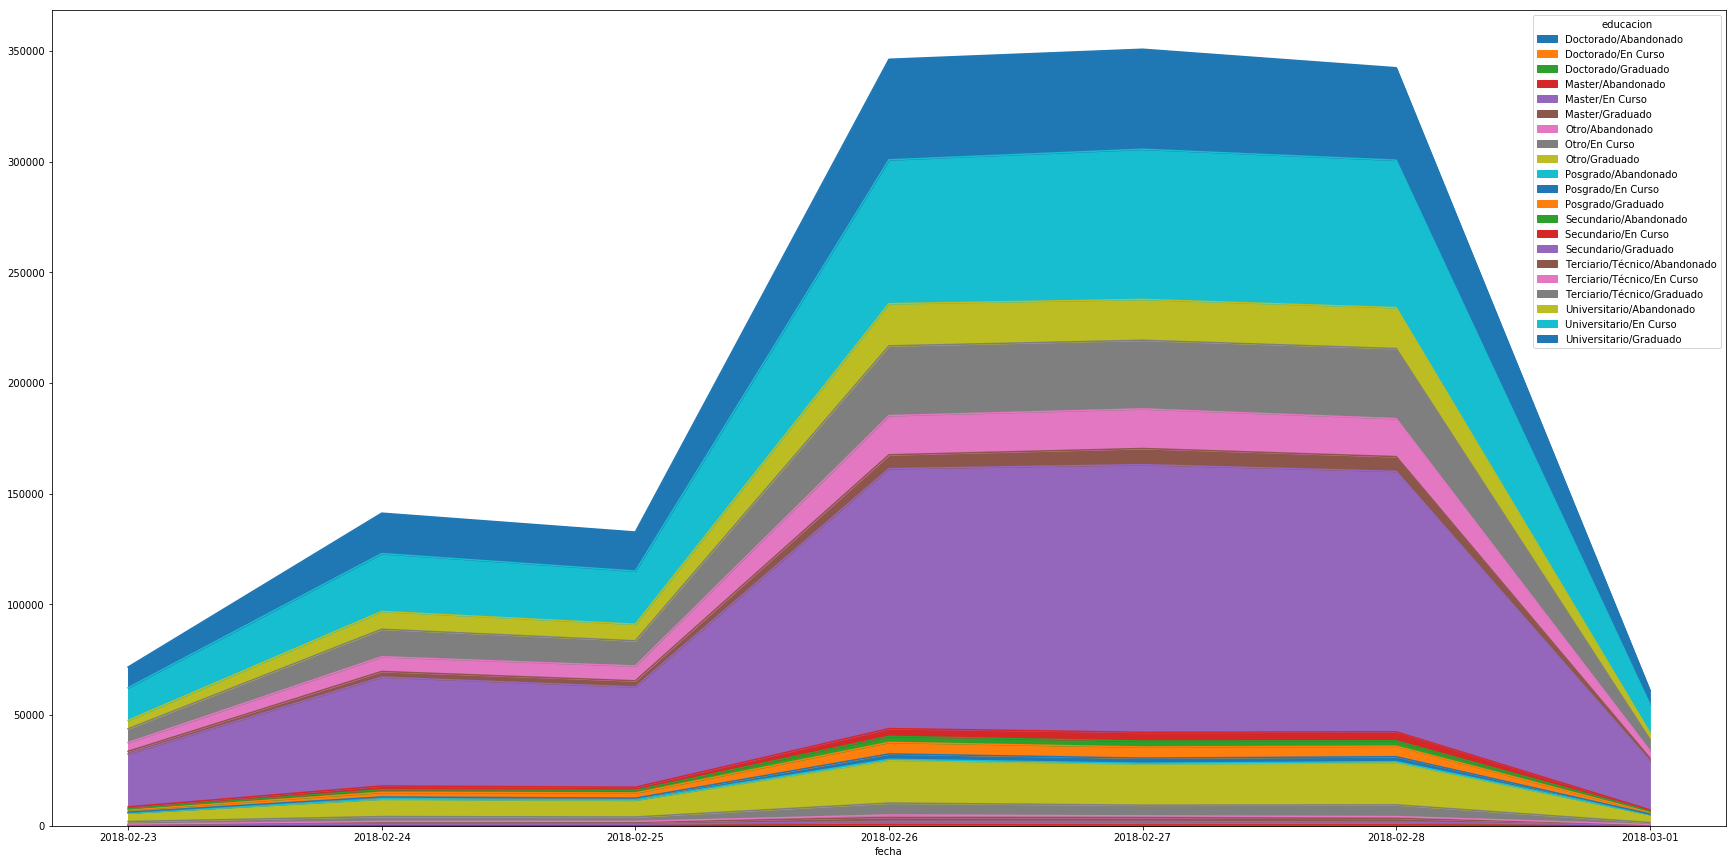

In [28]:
joined_df.plot.area(figsize= (30, 15), sort_columns=True).legend(loc=2, prop={'size': 6})